100%|██████████| 8/8 [00:00<00:00, 618.80it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


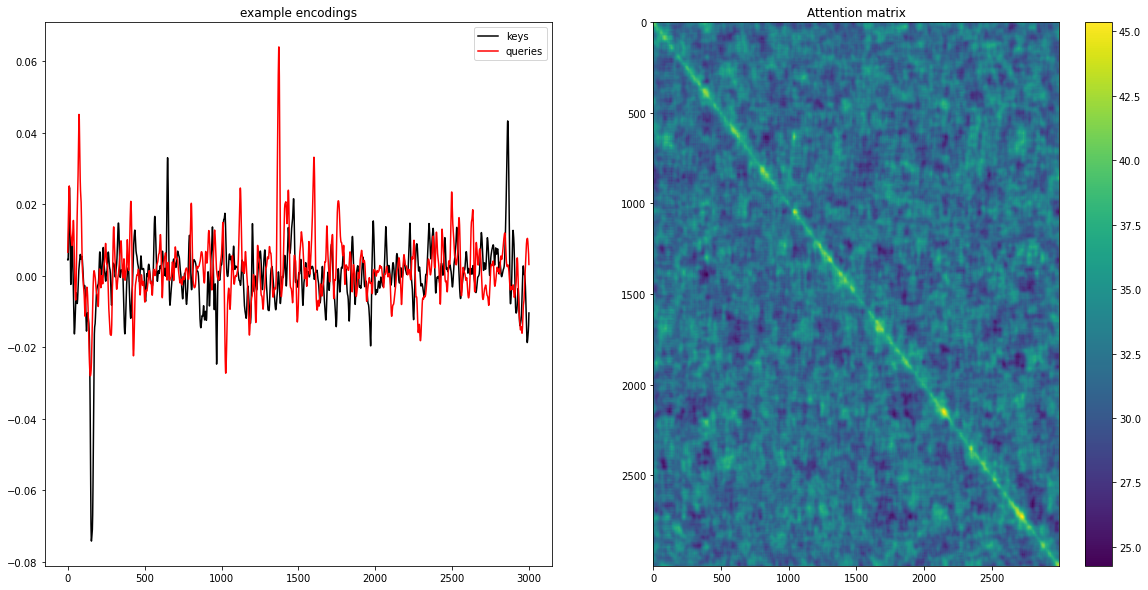

In [6]:
%load_ext autoreload
%autoreload 2

import torch
import spe
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sine or conv
conv = False

# number of layers to simulate
n_layers = 8

# dimension for the keys and queries
keys_dim = 64
spe_dim = 32
num_heads = 8
num_realizations = 64
num_sines = 20

# create the positional encoder, with a specified max lag
if conv:
    encoder = spe.ConvSPE(ndim=1, in_features=spe_dim, kernel_size=200, num_heads=num_heads, num_realizations=num_realizations)
else:
    encoder = spe.SineSPE(num_heads=num_heads, in_features=spe_dim, num_sines=num_sines, num_realizations=num_realizations)
encoder.to(device=device)

n = 3000
batchsize=16

# generate some keys and queries of shape (batchsize, num, n)
q = torch.ones(batchsize, n, num_heads, keys_dim, device=device, requires_grad=True)
k = torch.ones(batchsize, n, num_heads, keys_dim, device=device, requires_grad=True)

from tqdm import tqdm

loss = 0
for iteration in tqdm(range(n_layers)):
    # compute the average attention matrix
    q, k = encoder(q,k)

    A = torch.mm(q[0,:,0,:], k[0,:,0,:].T)

    loss = loss + A.sum()

A = torch.mm(q[0,:,0,:].detach(), k[0,:,0,:].T.detach())
    

# display some queries and keys
q = q.detach()
k = k.detach()

plt.figure(figsize=[20,10]);
plt.subplot(121)
plt.plot(k[0,:,0,0].cpu(),'k');
plt.plot(q[0,:,0,0].cpu(),'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(122);
plt.imshow(A.detach().cpu().numpy(), aspect='auto', interpolation='nearest');
plt.title('Attention matrix');
plt.colorbar();
